In [172]:
import importlib.util
if importlib.util.find_spec("numpy") is None:
    %pip install numpy
if importlib.util.find_spec("pandas") is None:
    %pip install pandas
if importlib.util.find_spec("matplotlib") is None:
    %pip install matplotlib
if importlib.util.find_spec("sklearn") is None:
    %pip install scikit-learn

# Part 1 Ridge Regression & Dataset Generation

Linear regression is a statistical method used to find a relationship between input features and an output variable. Simple models make predictions via computing a weighted sum of input features, for example:

$$ \hat{y} = \Theta_0 + \Theta_1 x_1 + \Theta_2x_2 + ... \Theta_nx_n $$

$\hat{y}$ = Predicted Value
 
$\Theta$ = Weights
 
$x$ = Instance Values


Which can be simplified to a matrix operation:

$$ \hat{y} = h_\Theta (x) = \Theta^Tx $$

$\hat{y}$ = Predicted Value
 
$\Theta$ = Weight Vector
 
$x$ = Instance Vector


## Ridge Regression


However, simple traditional regression models can fail to fit their data due to the underfitting or overfitting of their data. 

*Underfitting* can be minimized by:
   - Increasing model complexity
   - Feature engineering
   - Reducing model constraints

 *Overfitting* can be minimized by:
   - Increasing training data
   - Using cross-fold validation
   - Reducing dimensionality
   - Constraining the model 

Constraining the model requires the introduction of a *regularisation* term, which aims to reduce the effect of the training data , favouring the minimisation of model weights. 

 Within this notebook, I will be investigating a technique known as ridge regression regularisation. I will explore how it's implementation on linear and polynomial regression models can affect the performance of regression models, aiming to reduce overfitting of the data. Ridge regression, the *squared l2 regularisation*, is a regularised linear regression model, which contains a *regularisation* term which is added to the models cost function. 

The models regularisation term is:

$$ \alpha \sum_{i=1}^{n} \Theta^2_i + \epsilon $$

Thus the Ridge Regression cost function $J(\Theta)$ is:
$$ J(\Theta) = MSE(\Theta) + \alpha \sum_{i=1}^{n} \Theta^2_i + \epsilon $$

Vectorising the cost function gives us:

$$ \mathcal{L}(w) = ||y - Xw||^2_2 + \alpha ||w||^2_2 $$

Assuming that:

- $X \in \mathbb{R}^{n \times m}$ (design matrix with $n$ samples and $m$ features),
- $w \in \mathbb{R}^m$ (weight vector),
- $y \in \mathbb{R}^n$ (target vector),

The closed form solution that minimises $\mathcal{L}(w)$ is:


$$ \hat{w} = (X^\top X + \alpha I_m)^{-1} X^\top y $$

### Closed Form Ridge Regressor


Implementing the closed form solution is quite simple. We can define a ClosedFormRegressor, in the same format as sci-kit's other regressor. The class is initialised with empty weights, as they will be set via when a dataset is being fit.

In [ ]:
import numpy as np

class ClosedFormRegressor:
    def __init__(self, alpha: float):
        self.alpha = alpha
        self.w = None
    def fit(x,y): ...
    def predict(x): ...


### Fit Method

The `fit` method here implements the closed form solution. A bias-trick is introduced, by initializing a column of ones and then stacking it with x, and then setting $I_{0,0}$ to 0. The regularisation parameter is $\alpha$ is introduced here alongside $I$, and the weights are also initialised here.

In [ ]:
def fit(self, x, y):
      # Bias column
      b = np.ones(x.shape[0],)[:, np.newaxis]
      x = np.column_stack((b, x))

      I = np.identity(x.shape[1])
      I[0, 0] = 0

      # Closed form solution
      self.w = np.linalg.inv(x.T @ x + self.alpha * I) @ x.T @ y

ClosedFormRegressor.fit = fit

### Predict Method

The `predict` method is the same as other regression models, using the computational sum of weights, implemented via matrix multiplication, to produce a prediction:

$$ \hat{y} = X \hat{w} $$

In [ ]:
def predict(self, x):
      b = np.ones(x.shape[0],)[:, np.newaxis]
      x = np.column_stack((b, x))
      return x @ self.w

ClosedFormRegressor.predict = predict

## Polynomial Dataset Generation

In order to perform any sort of regression, we must obtain some data. For this investigation, I will be generating data randomly every time, using the function below:

$$ y = \sum_{k=0}^{n} a_k x^k + \epsilon $$

Where:

- $y$ is the output element.
- $x$ is the input feature, where $x \in [-5, 5]$.
- $a_k$ are polynomial co-efficients, where $a_k \sim U(0, 1)$.
- $n$ is the polynomial degree.
- $\epsilon$ is added in order to simulate noise, where $\epsilon \sim N(0, 1)$.

In [193]:
def generate_polynomial_dataset(degree: int, n_samples: int):
    x_set = []
    y_set = []
    for i in range(n_samples):
        x = np.random.uniform(-5, 5)
        y = sum(np.random.uniform(0, 1) * (x ** i) for i in range(degree+1)) + np.random.normal(0,1)
        x_set.append(x)
        y_set.append(y)
    return np.array(x_set), np.array(y_set)

### Example Dataset Generation and Visualisation

Thus, we can generate datasets of variable polynomial degree.

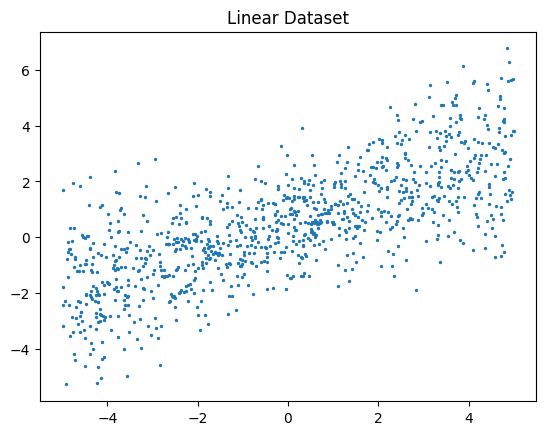

In [198]:
import matplotlib.pyplot as plt

x, y = generate_polynomial_dataset(1, 1000)
plt.scatter(x, y, s=2)
plt.title("Linear Dataset")
plt.show()

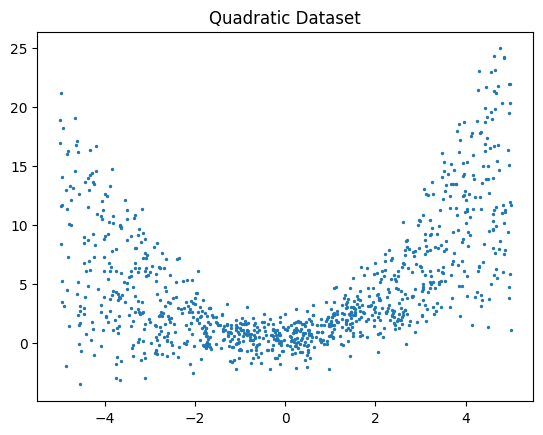

In [199]:

x, y = generate_polynomial_dataset(2, 1000)
plt.scatter(x, y, s=2)
plt.title("Quadratic Dataset")
plt.show()

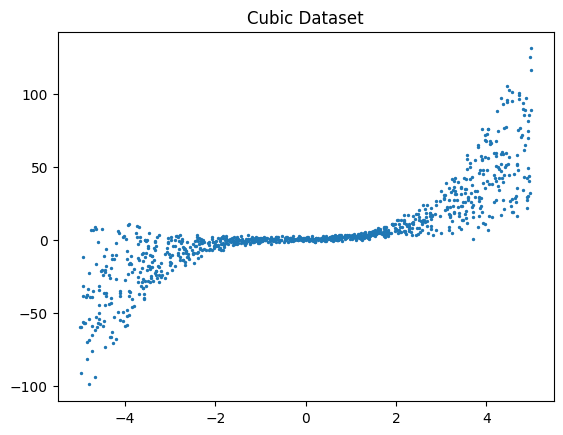

In [200]:
x, y = generate_polynomial_dataset(3, 1000)
plt.scatter(x, y, s=2)
plt.title("Cubic Dataset")
plt.show()

## Stochastic Gradient Descent Regression

In [178]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
test_alphas = [0, 0.1, 100,1000]

In [179]:

def get_split(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    if x_train.ndim == 1:
        x_train = x_train.reshape(-1, 1)
        x_test = x_test.reshape(-1, 1)
    return x_train, x_test, y_train, y_test

In [180]:
def plot_ridge_regression(x_test, y_test, results):
    for alpha in results.keys():
        sgd_pred = results[alpha][1]
        clf_pred = results[alpha][0]
        plt.scatter(x_test, sgd_pred, label='SGDRegressor with Ridge Regression',color='green', linewidth=5)
        plt.scatter(x_test, clf_pred, label='Closed Form Ridge Regression', color='red', linewidth=5)
        plt.scatter(x_test, y_test, color='blue', alpha=0.5)
        plt.title(f"Ridge Regression vs My Ridge Regression (alpha={alpha})")
        plt.legend()
        plt.show()


In [ ]:
def compare_alphas(alpha,x_train, x_test, y_train):
    results = {}
    sgd = SGDRegressor(penalty='l2', alpha=alpha, max_iter=1000)
    sgd.fit(x_train, y_train)
    sgd_pred = sgd.predict(x_test)
    sgd_pred = sgd_pred + sgd.intercept_

    
    clf = ClosedFormRegressor(alpha=alpha)
    clf.fit(x_train, y_train)
    clf_pred = clf.predict(x_test)
    clf_pred = clf_pred + clf.w[0]
    results.update({alpha: (clf_pred, sgd_pred)})
    #print intercepts
    print(f"SGDRegressor intercept: {sgd.intercept_}, Closed Form intercept: {clf.w[0]}")
    return results


### Linear Dataset regression

SGDRegressor intercept: [0.60337828], Closed Form intercept: 0.58628685326312


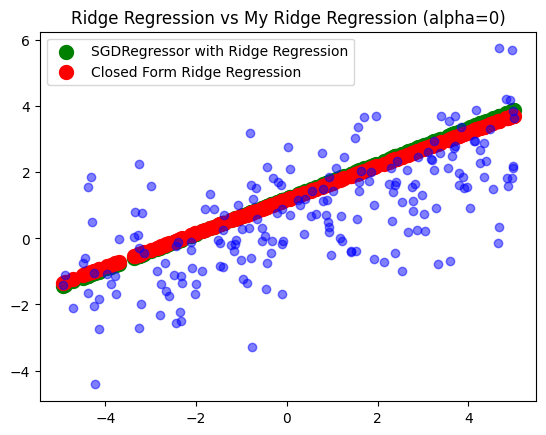

SGDRegressor intercept: [0.60127026], Closed Form intercept: 0.5862859610135984


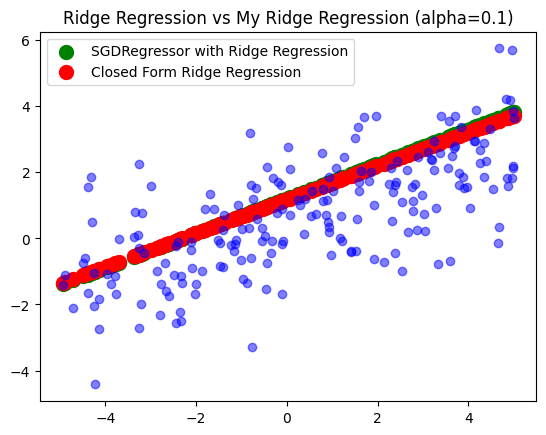

SGDRegressor intercept: [0.53720975], Closed Form intercept: 0.5854077218776783


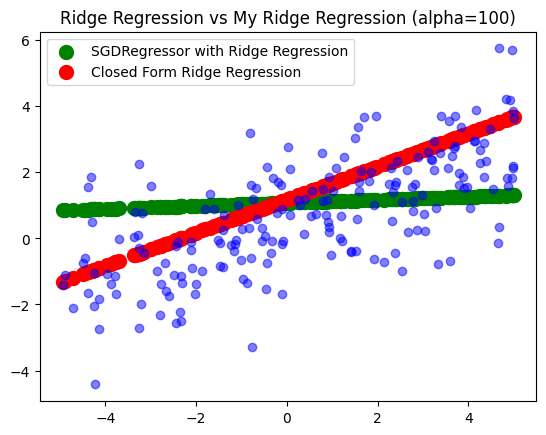

SGDRegressor intercept: [0.55570973], Closed Form intercept: 0.5785237837083308


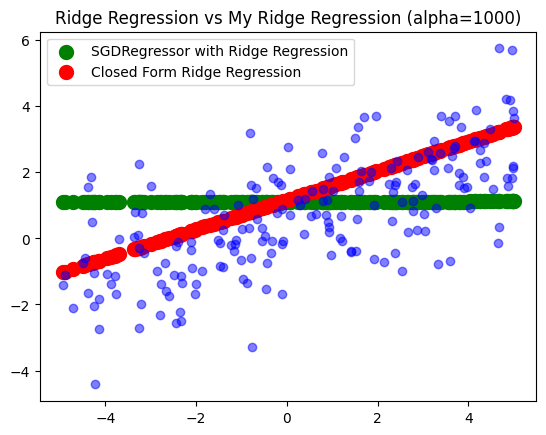

In [182]:
# Linear Datset Testing
xlin, ylin = generate_polynomial_dataset(1, 1000)
x_train, x_test, y_train, y_test = get_split(xlin, ylin)
for alpha in test_alphas:
        results  = compare_alphas(alpha, x_train, x_test, y_train)
        plot_ridge_regression(x_test, y_test, results)


### Quadratic Dataset Regression

In [183]:
# Quadratic dataset testing
xquad, yquad = generate_polynomial_dataset(2,1000)
x_train, x_test, y_train, y_test = get_split(xquad, yquad)
x_train_poly = np.column_stack((x_train, x_train**2))
x_test_poly = np.column_stack((x_test, x_test**2))

SGDRegressor intercept: [0.50378377], Closed Form intercept: 0.5144740669983461


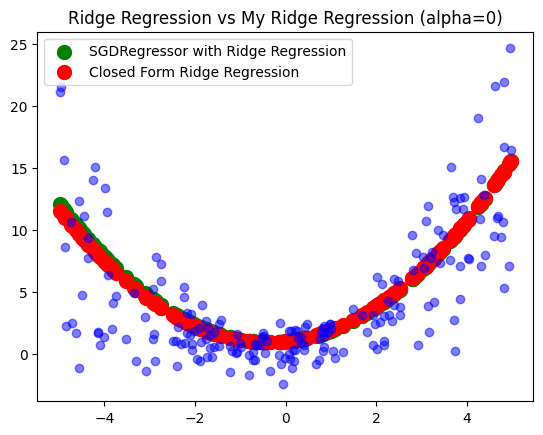

SGDRegressor intercept: [0.52145137], Closed Form intercept: 0.5144825419005917


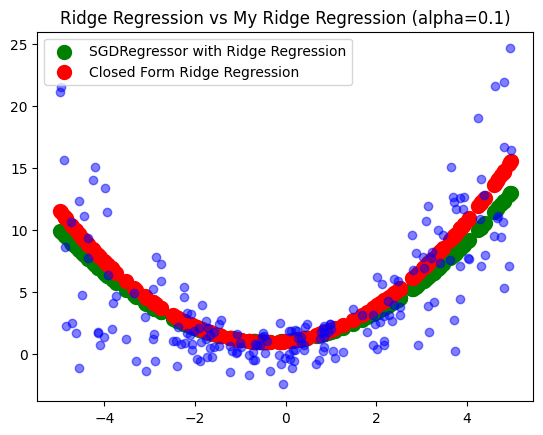

SGDRegressor intercept: [3.21703748], Closed Form intercept: 0.5229436249817909


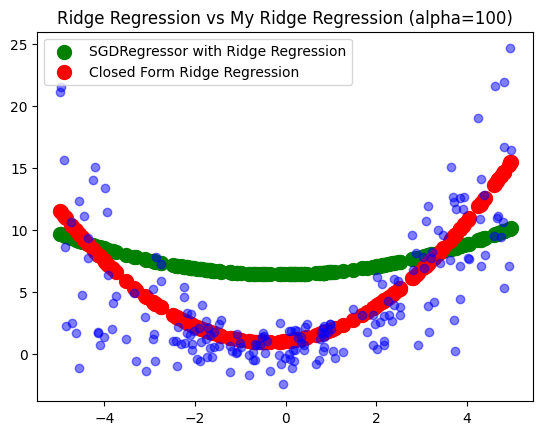

SGDRegressor intercept: [4.51301098], Closed Form intercept: 0.5985468837353233


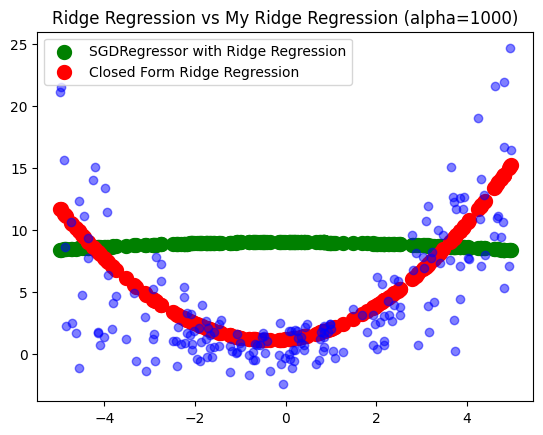

In [184]:
for alpha in test_alphas:
    results = compare_alphas(alpha, x_train_poly, x_test_poly, y_train)
    plot_ridge_regression(x_test, y_test, results)

### Cubic Dataset Regression


In [185]:
from sklearn.preprocessing import PolynomialFeatures

# Cubic dataset testing
x_cubic, y_cubic = generate_polynomial_dataset(3,1000)
x_train, x_test, y_train, y_test = get_split(x_cubic,y_cubic)


x_train_poly = np.column_stack((x_train, x_train**2))
x_test_poly = np.column_stack((x_test, x_test**2))
x_train_poly = np.column_stack((x_train_poly, x_train**3))
x_test_poly = np.column_stack((x_test_poly, x_test**3))

x_train_poly = StandardScaler().fit_transform(x_train_poly)
x_test_poly = StandardScaler().fit_transform(x_test_poly)

x_train_poly

array([[ 0.52587899, -0.82152461,  0.07389167],
       [ 1.15151094,  0.31016187,  0.73859616],
       [ 0.32712663, -1.00012885,  0.0232043 ],
       ...,
       [-1.28358091,  0.77049746, -1.10536935],
       [-0.78224461, -0.39470585, -0.25091456],
       [-1.0049793 ,  0.05445592, -0.53278226]], shape=(800, 3))

SGDRegressor intercept: [4.13349023], Closed Form intercept: 4.213150075165135


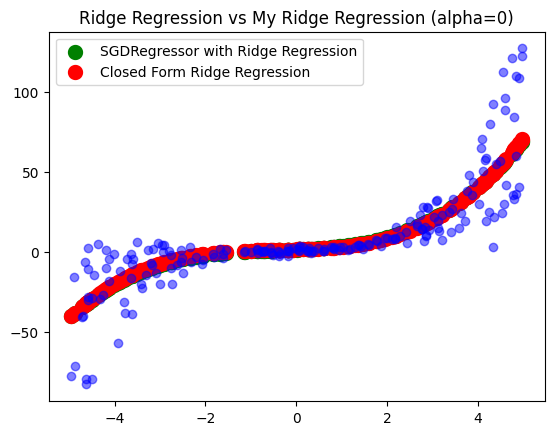

SGDRegressor intercept: [4.20329528], Closed Form intercept: 4.213150075165135


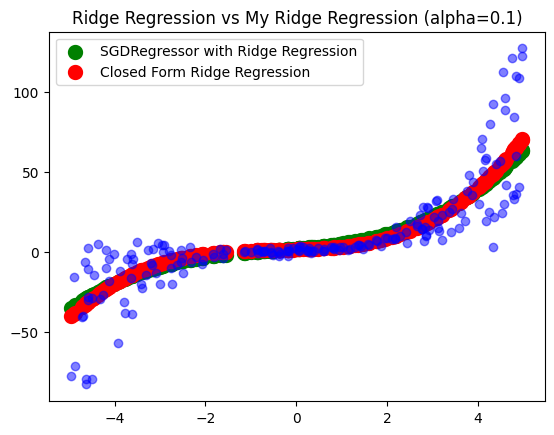

SGDRegressor intercept: [4.52559898], Closed Form intercept: 4.213150075165133


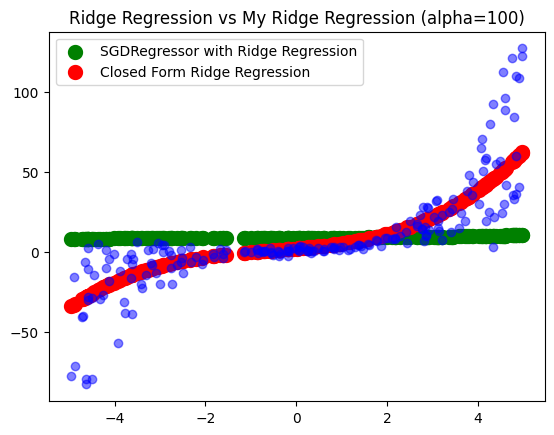

SGDRegressor intercept: [3.93172181], Closed Form intercept: 4.213150075165135


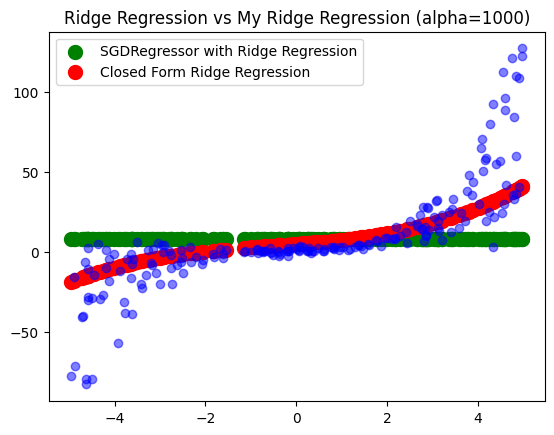

In [186]:

# Quadratic dataset testing
for alpha in test_alphas:
    results = compare_alphas(alpha, x_train_poly, x_test_poly, y_train)
    plot_ridge_regression(x_test, y_test, results)

# Part 2 Support Vector Classifiers

### Dataset

In [187]:
from sklearn.svm import SVC
import pandas as pd
data = pd.read_csv('wdbc.data', header=None)

# Column 0 is an ID, not needed
# Column 1 is the diagnosis, needed as the label of the classification
# 3 - 12 are mean values
# 13 - 22 are standard error
# 23 - 32 are worst

# Dropping the ID column
data.drop(columns=[0], inplace=True)

# Naming the columns
data.columns = ['diagnosis','radius_mean','texture_mean','perimeter_mean','area_mean',
               'smoothness_mean','compactness_mean','concavity_mean','concave_points_mean',
               'symmetry_mean','fractal_dimension_mean','radius_se','texture_se','perimeter_se',
               'area_se','smoothness_se','compactness_se','concavity_se','concave_points_se',
               'symmetry_se','fractal_dimension_se','radius_worst','texture_worst','perimeter_worst',
               'area_worst','smoothness_worst','compactness_worst','concavity_worst',
               'concave_points_worst','symmetry_worst','fractal_dimension_worst']

#### Dataset Cleaning

In [188]:
from sklearn.preprocessing import OrdinalEncoder

labels = data.iloc[:, 0].values

# get count of each label
count = np.unique(labels, return_counts=True)
print(count)
labels = pd.DataFrame(labels, columns=["diagnosis"])

enc = OrdinalEncoder(categories=[["M", "B"]])
labels_encoded = enc.fit_transform(labels)
labels_encoded = np.reshape(labels_encoded, -1)

mean_data = data.iloc[:, 1:11].values

stde_data = data.iloc[:, 11:21].values

worst_data = data.iloc[:, 21:31].values

mean_data.shape, stde_data.shape, worst_data.shape
labels_encoded.shape


(array(['B', 'M'], dtype=object), array([357, 212]))


(569,)

In [189]:
x_train, x_test, y_train, y_test = get_split(mean_data, labels_encoded)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((455, 10), (114, 10), (455,), (114,))

#### Dataset Splitting

### Grid Search and the SVC model

In [190]:
# Hyperparams to tune
# C
# degree, working with polynomial kernel
# gamma, working with rbf kernel

params = {
    'C': [0.1, 1, 10, 50],
    'degree': [2, 5, 9],
}

#### Precision vs Recall Curves

Precision: True Positives vs All positives
Recall: True Positives vs False Negatives: !!!!!! most important as we want to ensure we don't miss any malignant tumours.

Thresholds: [-1.59263003 -1.59211348 -1.5906502  -1.58502173 -1.57405737 -1.55648022
 -1.52235757 -1.51172853 -1.50742919 -1.50349218]
Thresholds: [-2.77922483 -2.75841617 -2.63301439 -2.63034314 -2.59717957 -2.56288158
 -2.547152   -2.47068234 -2.43789244 -2.43006719]
Thresholds: [-1.59263003 -1.59211348 -1.5906502  -1.58502173 -1.57405737 -1.55648022
 -1.52235757 -1.51172853 -1.50742919 -1.50349218]


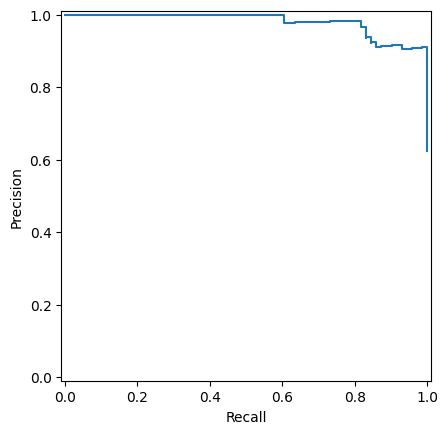

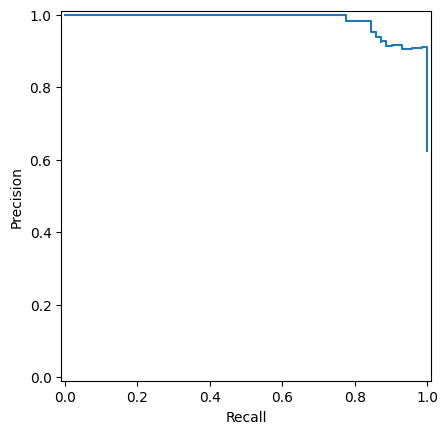

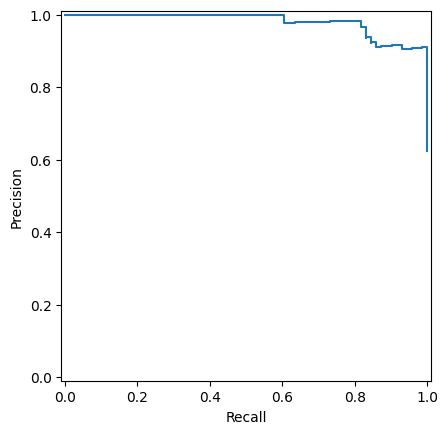

In [191]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

# list of param combinations, with precision, recall, accuracy

scoring = ['accuracy', 'precision', 'recall']

for sc in scoring:
    svc_gs = GridSearchCV(SVC(class_weight='balanced'), params, cv=5, scoring=sc)
    svc_gs.fit(x_train, y_train)

    best_model = svc_gs.best_estimator_

    # Get decision function scores for test set
    y_scores = best_model.decision_function(x_test)  # For SVM

    # Compute Precision, Recall, and Thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

    # Print the first few threshold values
    print("Thresholds:", thresholds[:10])  # Print first 10 threshold values

    # Plot the Precision-Recall curve
    display = PrecisionRecallDisplay(precision=precision, recall=recall)
    display.plot()


In [192]:
x_train, x_test, y_train, y_test = train_test_split(mean_data, labels, test_size=0.2, random_state=42)
svm = SVC(kernel='linear', C=1.0, random_state=42)
svm.fit(x_train, y_train)

y_pred = svm.predict(x_test)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

m:\work\ML-Project-1\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           B       0.96      0.94      0.95        71
           M       0.91      0.93      0.92        43

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.93       114
weighted avg       0.94      0.94      0.94       114

[[67  4]
 [ 3 40]]


### Testing the model

### Feasiblity